<a href="https://colab.research.google.com/github/ongtiongheng/rfml/blob/master/sutd_kwyoke_RF_modulation_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount("/content/gdrive/")
root_path = "/content/gdrive/MyDrive/"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
#%reset

%tensorflow_version 1.x
#from sklearn.externals import joblib
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, BatchNormalization, LSTM, Conv1D, MaxPooling1D, Conv2D, Input, Concatenate, Add
from keras.layers.convolutional import Convolution1D ,Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.initializers import glorot_uniform
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from scipy.interpolate import UnivariateSpline
from keras.utils import to_categorical
from sklearn import preprocessing
from keras.optimizers import Adam
from keras import regularizers


plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
EPOCHS = 100
NUM_CLASSES = 8
BATCH_SIZE = 1024
PATIENCE = 10

In [4]:
#Normalisation is very important
def iq2ampphase(inphase, quad):
    amplitude = np.sqrt(np.square(inphase) + np.square(quad))
    amp_norm = np.linalg.norm(amplitude) #L2 norm
    amplitude = amplitude/amp_norm #normalise
    phase = np.arctan(np.divide(quad, inphase))
    phase = 2.*(phase - np.min(phase))/np.ptp(phase)-1 #rescale phase to range [-1, 1]
    return amplitude, phase

#convert array of multiple iq samples into array of multiple ampphase samples
def arr_iq2ap(X):
  X_ap = []
  for k in range(X.shape[0]):
    I = X[k][0,:]
    Q = X[k][1,:]
    amp, phase = iq2ampphase(I, Q)
    ap = np.array([amp, phase])
    X_ap.append(ap)
  X_ap = np.array(X_ap)
  return X_ap

In [5]:
def generate_confusion_matrix(model, X,y, one_hot_transformer, batch_size):
    """
      y is the one hot encoded label vector passed to the model.evaluate
    """
    mod_to_idx = {mod:idx for idx,mod in enumerate(one_hot_transformer.classes_)} # use this to map modulation name to index
    y_hat = model.predict(X, batch_size)
    y_hat_onehot = np.zeros_like(y_hat)
    y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
    y_hat_mod = one_hot_transformer.inverse_transform(y_hat_onehot) # transform predictions to strings
    y_mod = one_hot_transformer.inverse_transform(y) # transform ground truth back to strings
    confusion_mat = np.zeros([NUM_CLASSES,NUM_CLASSES])

    acc = np.mean(y_mod == y_hat_mod)
    # fill in the confusion matrix
    for i in range(y.shape[0]):
        
        true_idx = mod_to_idx[y_mod[i]]
        pred_idx = mod_to_idx[y_hat_mod[i]]          
        confusion_mat[pred_idx,true_idx] += 1

    # normalize the matrix column wise
    for i in range(NUM_CLASSES):
        if np.sum(confusion_mat[:,i]) > 0:
          confusion_mat[:,i] /= np.sum(confusion_mat[:,i])
    
    return confusion_mat,acc

 
import seaborn as sns
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax, cmap=cmap); #annot=True to annotate cells
  
  plt.title(title)
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels)
  plt.tight_layout()
  plt.ylabel('Predicted label')
  plt.xlabel('True label')

In [6]:
class ModelEvaluater:
  def __init__(self, model, X_train, y_train, X_val, y_val, X_test, y_test,
               labels_test, batch_size, model_name, channels_first=True, feature_type=1):
    if channels_first:
      self.X_train = X_train
      self.X_val = X_val
      self.X_test = X_test
    else:
      self.X_train = X_train.reshape([X_train.shape[0], X_train.shape[2], X_train.shape[1]])
      self.X_val = X_val.reshape([X_val.shape[0], X_val.shape[2], X_val.shape[1]])
      self.X_test = X_test.reshape([X_test.shape[0], X_test.shape[2], X_test.shape[1]])
    
    self.feature_type = feature_type
      
    self.model = model
    self.y_train = y_train
    self.y_val = y_val
    self.y_test = y_test
    self.labels_test = labels_test
    self.model_name = model_name
    self._checkpoint_callback = ModelCheckpoint(filepath=root_path + '%s-weights-{epoch}.hdf5' % self.model_name,
                                                verbose=1, save_best_only=True)
    self._train_accs = []
    self._val_accs = []
    self._snr_accs = []
    
    self.batch_size = batch_size
    
    # get the modulation types into an array
    self.mod_types = np.unique(labels_test[:,0])
  
    # fit a label binarizer 
    self.mod_to_onehot = preprocessing.LabelBinarizer()
    self.mod_to_onehot.fit(self.mod_types)

    # transform the y values to one-hot encoding
    self.y_train = self.mod_to_onehot.transform(y_train)
    self.y_val = self.mod_to_onehot.transform(y_val)
    self.y_test = self.mod_to_onehot.transform(y_test)
    
    print('y_train %s' %(y_train.shape))
    print('y_val %s' %(y_val.shape))
    print('y_test %s' %(y_test.shape))
    

    
  def fit(self, epochs, patience=10):
    curr_X, curr_y = self.X_train, self.y_train
    val_X, val_y = self.X_val, self.y_val
    callbacks = [self._checkpoint_callback, EarlyStopping(patience=patience)]
   
     # train the model
    model_info = self.model.fit(curr_X, curr_y,
                                batch_size=self.batch_size,
                                epochs=epochs,
                                verbose=1,
                                validation_data=(val_X, val_y),
                                callbacks=callbacks)

    self._train_accs.extend(model_info.history['accuracy'])
    self._val_accs.extend(model_info.history['val_accuracy'])



  def print_summary(self):
    # plot validation accuracy vs training accuracy
    plt.plot(np.arange(len(self._train_accs)), self._train_accs, '-o', label='training accuracy')
    plt.plot(np.arange(len(self._val_accs)), self._val_accs, '-o', label='validation accuracy')
    plt.legend()
    plt.xlabel('epochs')
    plt.title('%s -validation vs training accuracy' %(self.model_name))
    display(plt.show())

    #plot confusion matrix for all, low, med and high SNR
    snr_ranges = [(-20, 20), (-20, -11), (-10, 5), (6, 20)]
    for snr_rng in snr_ranges:
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where((labels_test >= snr_rng[0]) & (labels_test <=snr_rng[1]))
      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]
      conf_mat, acc = generate_confusion_matrix(self.model, X_snr, y_snr, self.mod_to_onehot, self.batch_size)
      plot_confusion_matrix(conf_mat, labels=self.mod_to_onehot.classes_, 
                            title='%s- Confusion Matrix (SNR in range %s) - acc=%s' %(self.model_name, snr_rng, acc*100))
      plt.show()

    # get accuracy per snr
    snr_accs = {}
    snrs = np.unique(np.unique(self.labels_test,axis=0)[:,1]).astype('int32')
    for snr in sorted(snrs):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where(labels_test == snr)

      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]

      #calculate acc for each snr
      mod_to_idx = {mod:idx for idx,mod in enumerate(self.mod_to_onehot.classes_)} # use this to map modulation name to index
      y_hat = self.model.predict(X_snr, self.batch_size)
      y_hat_onehot = np.zeros_like(y_hat)
      y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
      y_hat_mod = self.mod_to_onehot.inverse_transform(y_hat_onehot) # transform predictions to strings
      y_mod = self.mod_to_onehot.inverse_transform(y_snr) # transform ground truth back to strings

      acc = np.mean(y_mod == y_hat_mod)
      snr_accs[snr] = acc

    # plot the accuracy against the snr
    plt.plot(list(snr_accs.keys()),list(snr_accs.values()))
    plt.xlabel("Signal to Noise Ratio")
    plt.ylabel("Classification Accuracy")
    plt.xticks(list(snr_accs.keys()))
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.grid(True)
    plt.show()


  def accpersnr_model(self):
    snr_accs = {}
    snrs = np.unique(np.unique(self.labels_test,axis=0)[:,1]).astype('int32')
    for snr in sorted(snrs):
      labels_test = np.array([int(lbl) for lbl in self.labels_test[:,1]])
      idx = np.where(labels_test == snr)

      if self.feature_type==2:
        tmp_img = self.X_test[0]
        tmp_time = self.X_test[1]
        X_snr = [tmp_img[idx], tmp_time[idx]]
      elif self.feature_type==1:
        X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]

      #calculate acc for each snr
      mod_to_idx = {mod:idx for idx,mod in enumerate(self.mod_to_onehot.classes_)} # use this to map modulation name to index
      y_hat = self.model.predict(X_snr, self.batch_size)
      y_hat_onehot = np.zeros_like(y_hat)
      y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
      y_hat_mod = self.mod_to_onehot.inverse_transform(y_hat_onehot) # transform predictions to strings
      y_mod = self.mod_to_onehot.inverse_transform(y_snr) # transform ground truth back to strings

      acc = np.mean(y_mod == y_hat_mod)
      snr_accs[snr] = acc

    return snr_accs

In [14]:
import joblib
data = joblib.load(root_path + 'rml_trainvaltest.hdf5')


In [15]:
#quick understanding of data
print(data.keys())
print('Train val test size: ', data['train']['X'].shape, data['val']['X'].shape, data['test']['X'].shape)
print('Check if data is shuffled: ', data['val']['labels'][:10])

uniq, counts = np.unique(data['train']['labels'][:,1], return_counts = True)
print('Check snr range: ', uniq)
print('Check distribution of samples across SNR: ', counts)

uniq, counts = np.unique(data['train']['labels'][:,0], return_counts = True)
print('Check modulation types: ', uniq)
print('Check distribution of samples across modulation types: ', counts)

dict_keys(['train', 'val', 'test'])
Train val test size:  (107200, 2, 128) (20800, 2, 128) (32000, 2, 128)
Check if data is shuffled:  [['dBPSK' '-20']
 ['a64QAM' '-4']
 ['cCPFSK' '8']
 ['bQPSK' '-8']
 ['d4PAM' '-16']
 ['cCPFSK' '12']
 ['d4PAM' '-4']
 ['a16QAM' '0']
 ['a64QAM' '0']
 ['a64QAM' '-8']]
Check snr range:  ['-10' '-12' '-14' '-16' '-18' '-2' '-20' '-4' '-6' '-8' '0' '10' '12'
 '14' '16' '18' '2' '4' '6' '8']
Check distribution of samples across SNR:  [5392 5284 5482 5363 5291 5334 5361 5429 5328 5372 5345 5305 5362 5316
 5324 5408 5374 5401 5396 5333]
Check modulation types:  ['a16QAM' 'a64QAM' 'b8PSK' 'bQPSK' 'cCPFSK' 'cGFSK' 'd4PAM' 'dBPSK']
Check distribution of samples across modulation types:  [13521 13310 13361 13478 13329 13451 13283 13467]


In [16]:
#load data
X_train = data['train']['X']
y_train = data['train']['labels'][:,0]
labels_train = data['train']['labels'] 

X_val = data['val']['X']
y_val = data['val']['labels'][:,0]
labels_val = data['val']['labels'] 

X_test = data['test']['X']
y_test = data['test']['labels'][:,0]
labels_test = data['test']['labels'] 

In [17]:
#convert to ampphase
X_ap_train = arr_iq2ap(X_train)
X_ap_val = arr_iq2ap(X_val)
X_ap_test = arr_iq2ap(X_test)

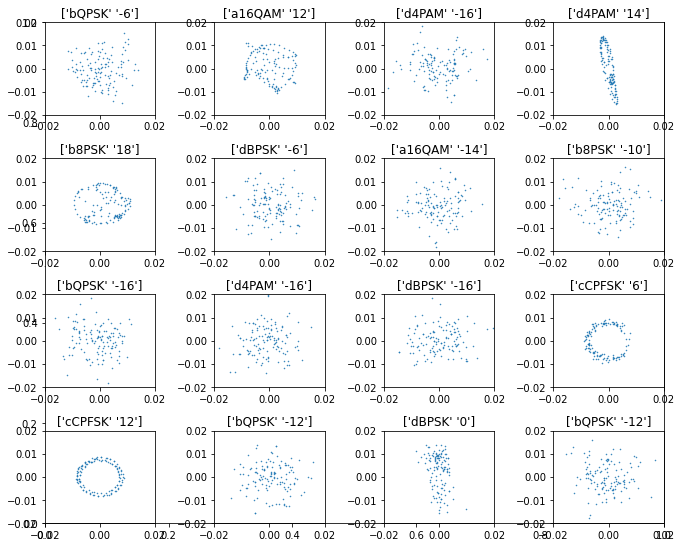

In [18]:
#constellation diagrams
fig, ax = plt.subplots(figsize=(10,8)) 
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    I = X_train[i][0,:]
    Q = X_train[i][1,:]
    plt.plot(I, Q, '.', markersize=1)
    plt.xlim(-0.02, 0.02)
    plt.ylim(-0.02, 0.02)
    plt.title(str(labels_train[i]))
    plt.tight_layout()
plt.show()

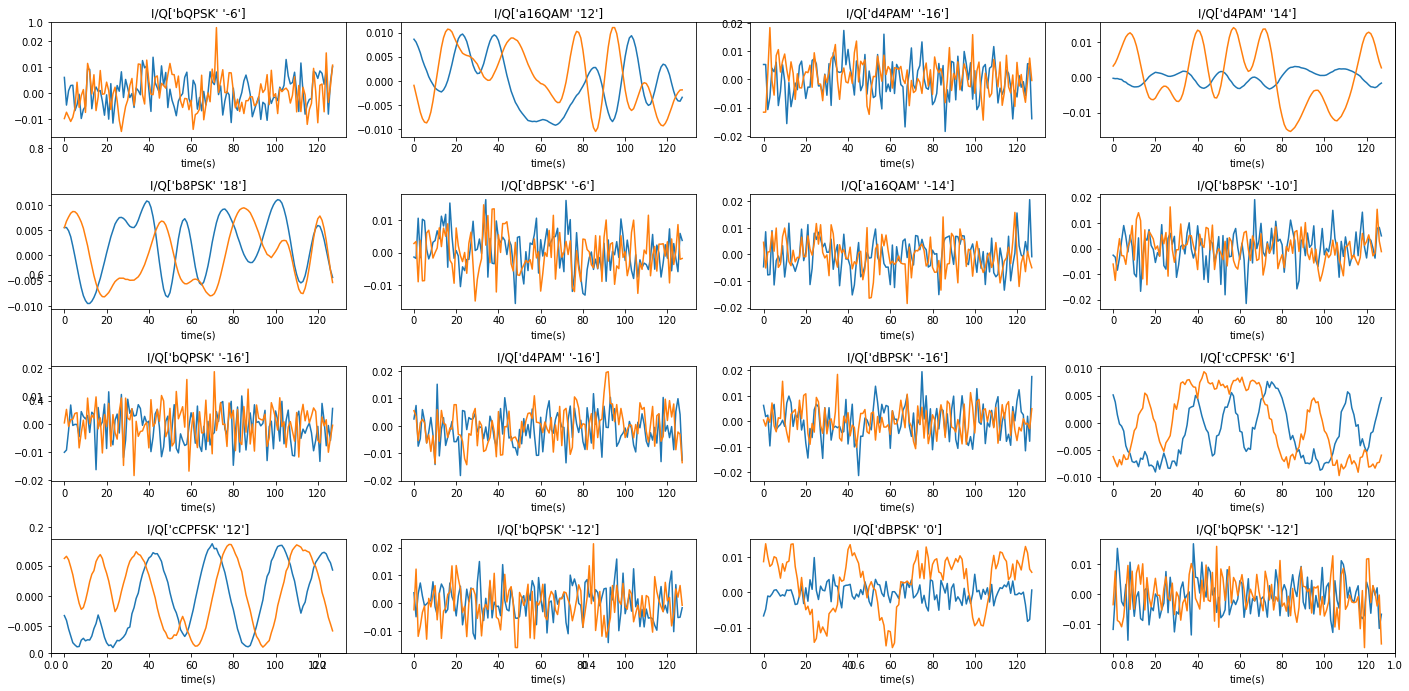

In [19]:
#IQ time-series
fig, ax = plt.subplots(figsize=(20,10)) 
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    I = X_train[i][0,:]
    Q = X_train[i][1,:]
    ax.set_xlabel('time(s)')
    ax.plot(I)
    ax.plot(Q)
    plt.title('I/Q' + str(labels_train[i]))
    plt.tight_layout()
plt.show()

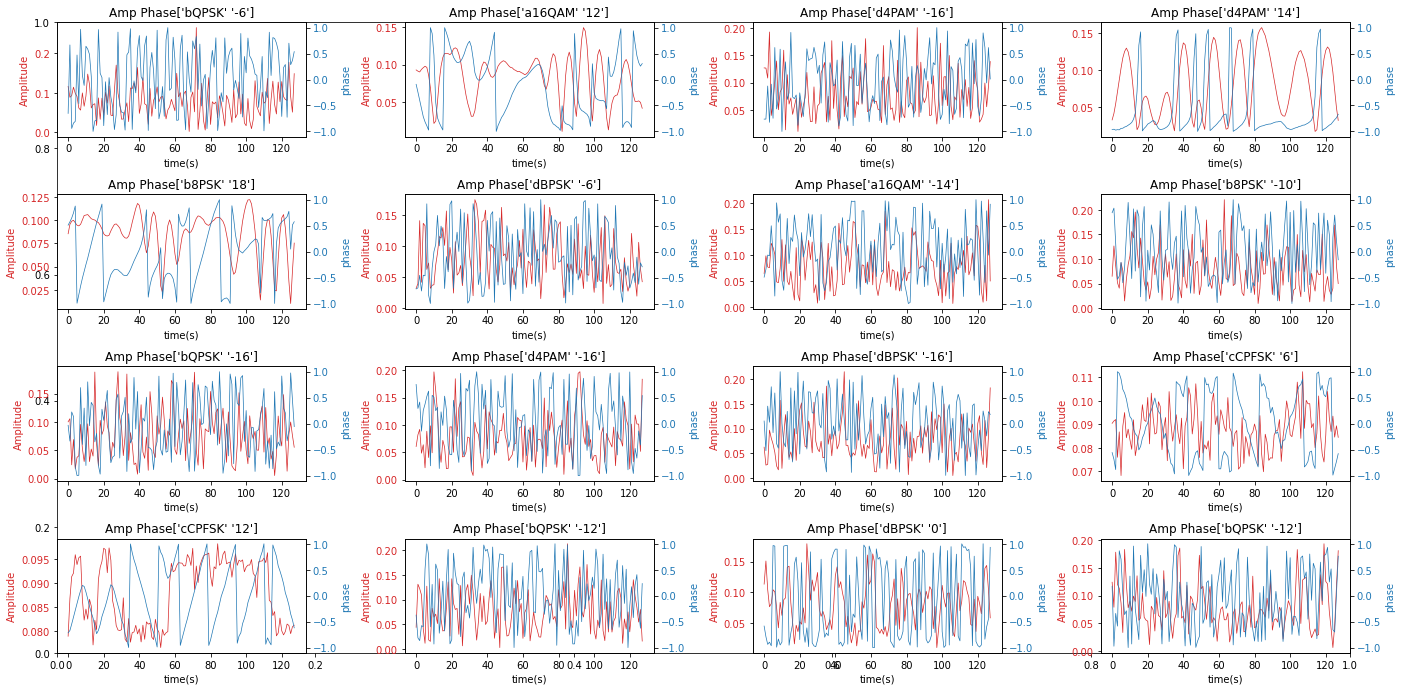

In [20]:
#Amp-Phase time-series
fig, ax = plt.subplots(figsize=(20,10)) 
for i in range(16):
    ax = fig.add_subplot(4,4,i+1)
    amp = X_ap_train[i][0,:]
    phase = X_ap_train[i][1,:]
    ax.set_xlabel('time(s)')
    ax.set_ylabel('Amplitude',color='tab:red')
    ax.plot(amp, color='tab:red', linewidth=0.7)
    ax.tick_params(axis='y', labelcolor='tab:red')
    ax2 = ax.twinx()
    ax2.set_ylabel('phase', color='tab:blue')
    ax2.plot(phase, color='tab:blue', linewidth=0.7)
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    plt.title('Amp Phase' + str(labels_train[i]))
    plt.tight_layout()
plt.show()

Basic CNN: 2 conv + 2 dense

In [21]:
def build_cnn_net(X1, X2):
    dr = 0.6 # dropout rate (%)
    
    cnn_model = Sequential()
    cnn_model.add(Reshape((1,X1, X2), input_shape=(X1, X2)))
    cnn_model.add(Convolution2D(256, (1,3), padding="valid", activation='relu', init='glorot_uniform', data_format="channels_first"))
    cnn_model.add(Dropout(dr))
    cnn_model.add(Convolution2D(80, (2, 3), padding="valid", activation='relu', init='glorot_uniform', data_format="channels_first"))
    cnn_model.add(Dropout(dr))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(256, activation='relu', init='he_normal'))
    cnn_model.add(Dropout(dr))
    cnn_model.add(Dense(NUM_CLASSES, activation='softmax', init='he_normal'))
    cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    cnn_model.summary()
    return cnn_model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 3), padding="valid", activation="relu", data_format="channels_first", kernel_initializer="glorot_uniform")`
  


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 2, 126)       1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 2, 126)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 1, 124)        122960    
_________________________________________________________________
dropout_2 (Dropout)          (None, 80, 1, 124)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(80, (2, 3), padding="valid", activation="relu", data_format="channels_first", kernel_initializer="glorot_uniform")`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="he_normal")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="softmax", kernel_initializer="he_normal")`
  del sys.path[0]


y_train 107200
y_val 20800
y_test 32000

Train on 107200 samples, validate on 20800 samples
Epoch 1/100
107200/107200 [==============================] - 9s 87us/step - loss: 2.0796 - accuracy: 0.1238 - val_loss: 2.0796 - val_accuracy: 0.1274

Epoch 00001: val_loss improved from inf to 2.07955, saving model to /content/gdrive/MyDrive/CNN-Net8-weights-1.hdf5
Epoch 2/100
107200/107200 [==============================] - 5s 50us/step - loss: 2.0795 - accuracy: 0.1237 - val_loss: 2.0796 - val_accuracy: 0.1201

Epoch 00002: val_loss did not improve from 2.07955
Epoch 3/100
107200/107200 [==============================] - 5s 50us/step - loss: 2.0795 - accuracy: 0.1254 - val_loss: 2.0795 - val_accuracy: 0.1228

Epoch 00003: val_loss improved from 2.07955 to 2.07954, saving model to /content/gdrive/MyDrive/CNN-Net8-weights-3.hdf5
Epoch 4/100
107200/107200 [==============================] - 5s 51us/step - loss: 2.0795 - accuracy: 0.1259 - val_loss: 2.0796 - val_accuracy: 0.1201

Epoch 00004: val_

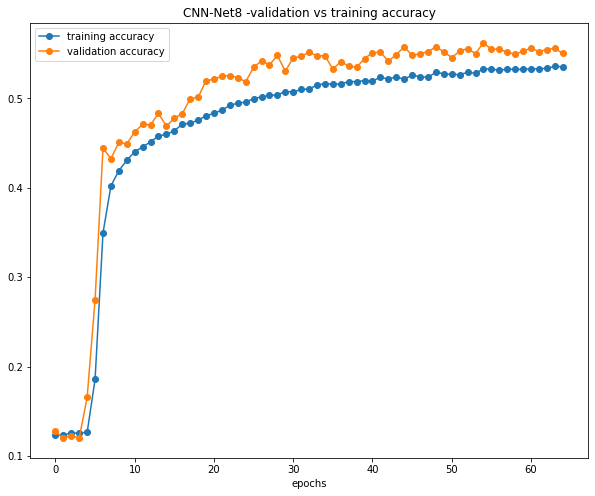

None

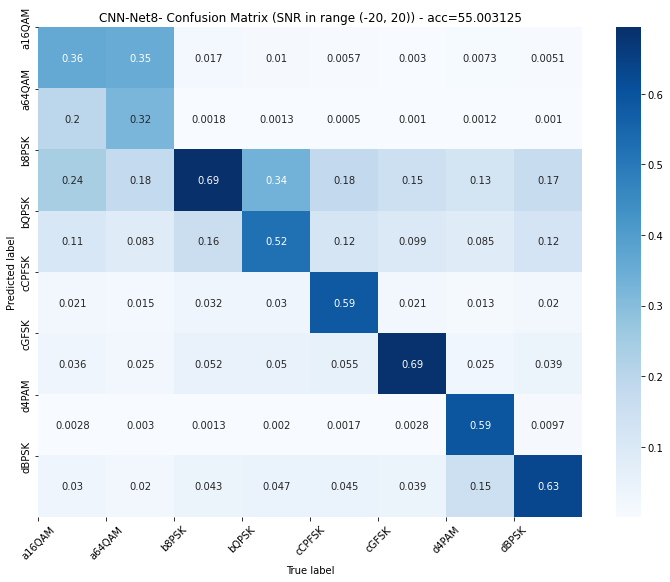

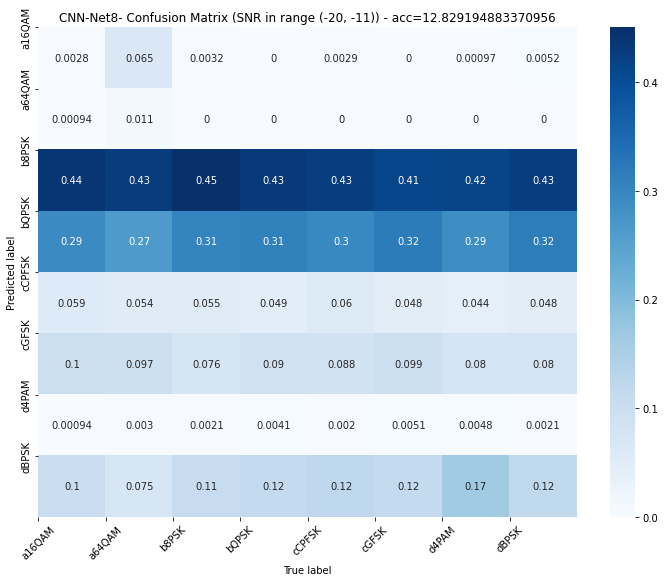

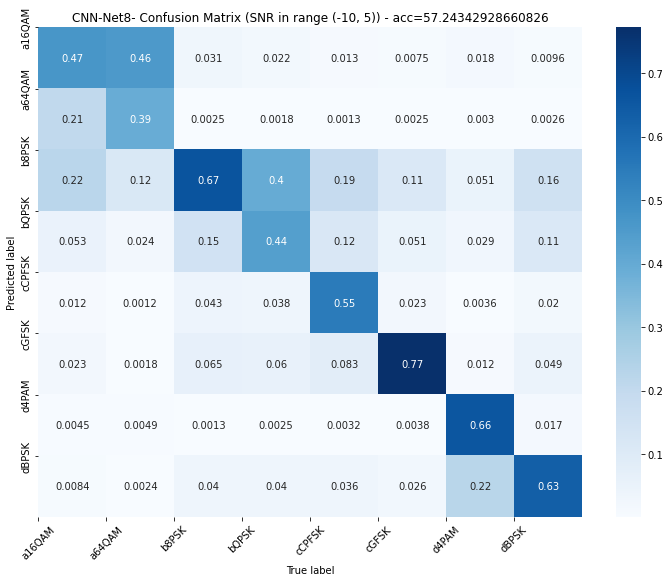

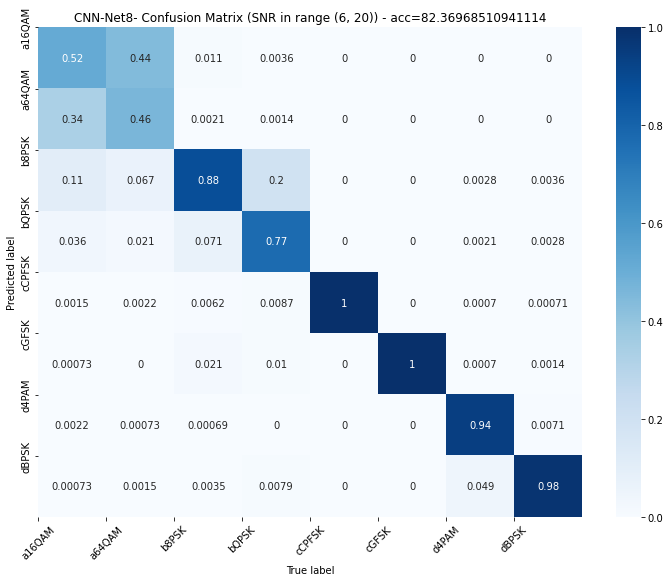

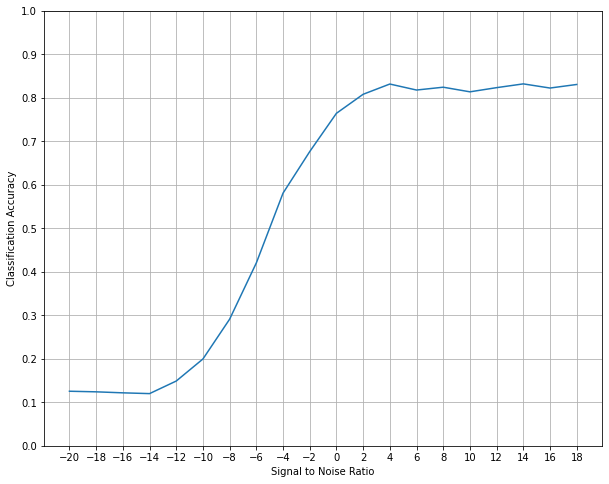

In [22]:
cnn_model = build_cnn_net(X_test.shape[1], X_test.shape[2])
cnn_model_evaluater = ModelEvaluater(cnn_model, X_train, y_train, X_val, y_val, X_test, y_test, labels_test, BATCH_SIZE, 'CNN-Net8' )
cnn_model_evaluater.fit(EPOCHS, patience=PATIENCE)
cnn_model_evaluater.print_summary()

AP Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 3), padding="valid", activation="relu", data_format="channels_first", kernel_initializer="glorot_uniform")`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(80, (2, 3), padding="valid", activation="relu", data_format="channels_first", kernel_initializer="glorot_uniform")`
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="he_normal")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, activation="softmax", kernel_initializer="he_normal")`
  del sys.path[0]


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 2, 126)       1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256, 2, 126)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 80, 1, 124)        122960    
_________________________________________________________________
dropout_5 (Dropout)          (None, 80, 1, 124)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9920)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

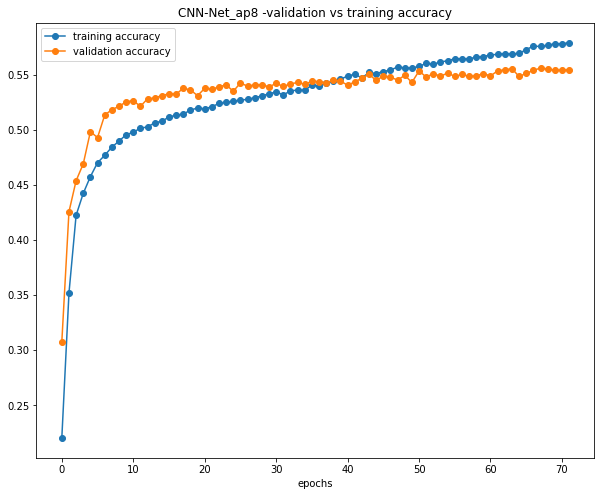

None

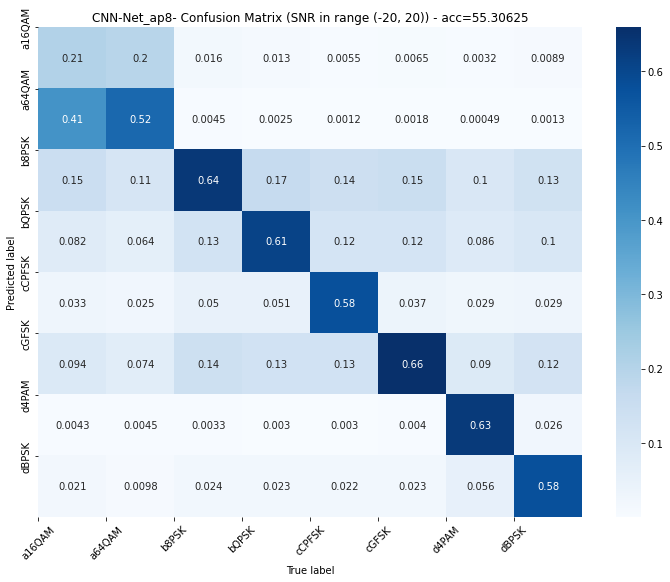

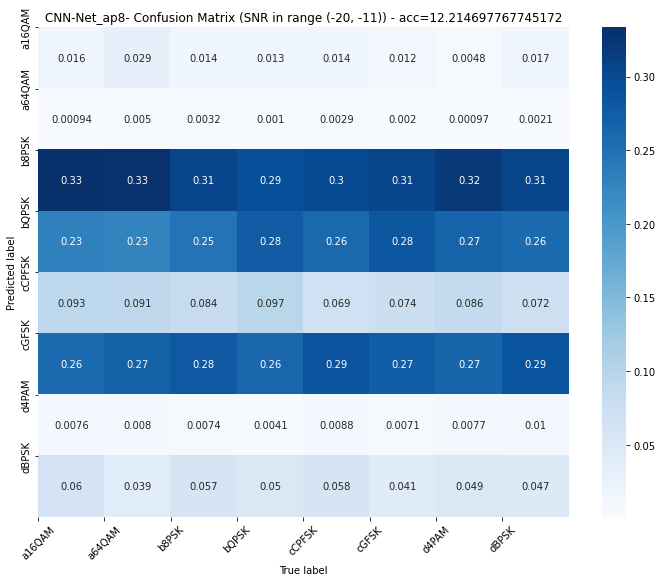

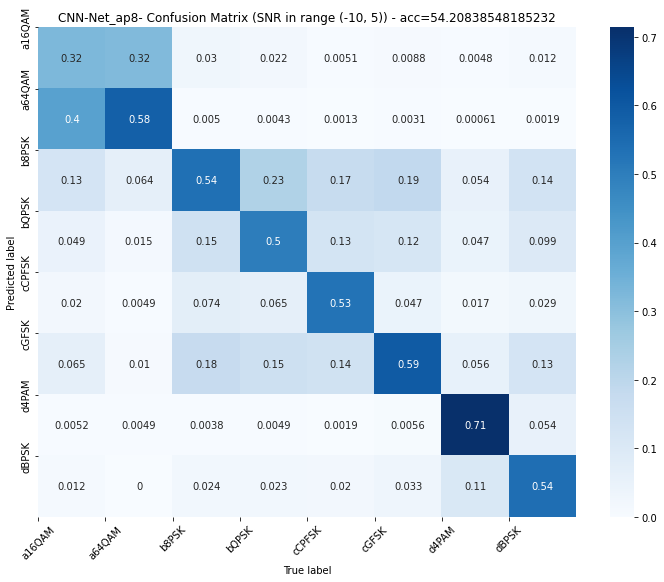

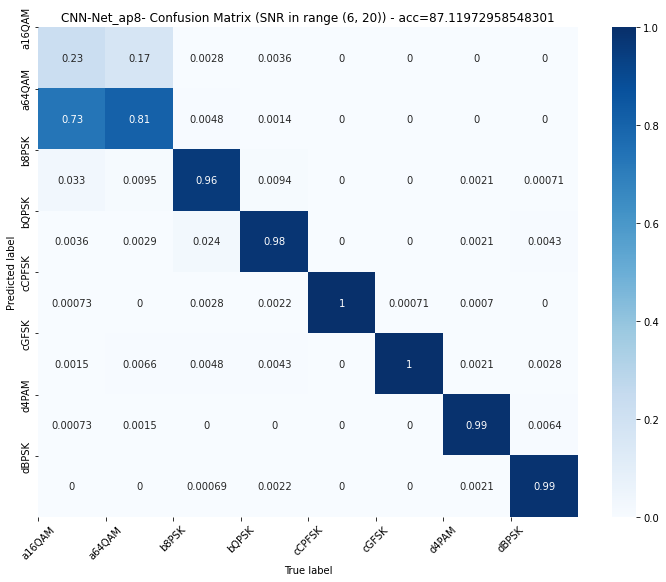

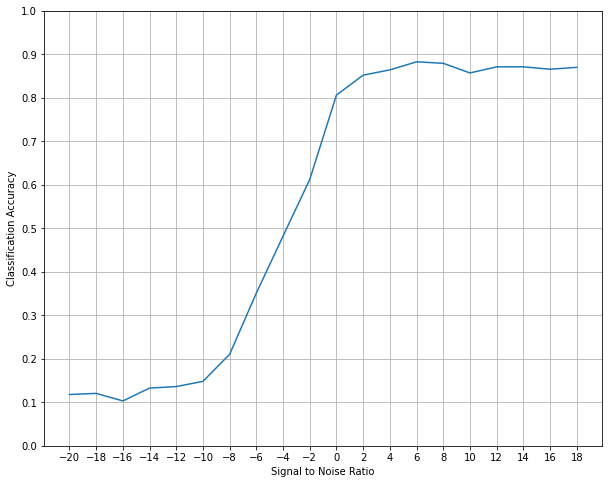

In [23]:
cnn_ap_model = build_cnn_net(X_ap_test.shape[1], X_ap_test.shape[2])
cnn_ap_model_evaluater = ModelEvaluater(cnn_ap_model, X_ap_train, y_train, X_ap_val, y_val, X_ap_test, y_test, labels_test, BATCH_SIZE, 'CNN-Net_ap8' )
cnn_ap_model_evaluater.fit(EPOCHS, patience=PATIENCE)
cnn_ap_model_evaluater.print_summary()